# Deep Deterministic Policy Gradient


### General Information
* Authors: Daniil Bobrovskiy and Nicolaj Schmid
* Course: Artificial Neural Networks and Reinforcement Learning (CS-456, EPFL)
* Project: DDPG implementation to balance an inverted pendulum
* GitHub: https://github.com/nas-git-nas/ANNRL_Project_DDPG
* References: 
    * Code: based on OpenAI's _Gym_ environment
    * Algorithm: _Continuous control with deep reinforcement learning_ from Timothy P. Lillicrap, Jonathan J. Hunt, Alexander Pritzel, Nicolas Heess, Tom Erez, Yuval Tassa, David Silver and Daan Wierstra, 2019


### Notebook Structure
This notebook is structured in three parts:
1. __Imports__: import all libraries
2. __Classes__: DDPG implementation split in different classes
3. __Training and Results__: run the algorithms and show the results
    * Heuristic Policy
    * Q-function
    * Minimal Implementation of DDPG
    * Target DDPG
    * Ornstein-Uhlenbeck Noise
    * Code to reproduce the exact figures from the report

For the __Target DDPG__ and the __Ornstein-Uhlenbeck Noise__ the optimal parameters _tau_ and _theta_ are explored. Please modify the parameter in the beginning of the code cell to train the corresponding model.

### Report
Please read the report for the discussion of the results. Note that due to space limitations not all plots are shown in the report. Also, for the __Target DDPG__ and the __Ornstein-Uhlenbeck Noise__ the loss curves are summurized in one figure for all different parameters _tau_ and _theta_. To reproduce these and other traning curves from the report, please see the code in the last section of this notebook. Since the files with losses of the exact models we used for the report are required to plot them, these files need to be downloaded from our GitHub prior to plotting.

## Imports

In [2]:
import os
import torch
import gym
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from abc import abstractmethod
from datetime import datetime

In [3]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)

## Classes

### Environment

In [4]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

### Replay Buffer

In [5]:
class ReplayBuffer():
    def __init__(self, buffer_size, seed):     
        self._buffer = { 
            "state" : torch.empty((buffer_size,3), dtype=torch.float32, requires_grad=False),
            "action" : torch.empty((buffer_size), dtype=torch.float32, requires_grad=False),
            "reward" : torch.empty((buffer_size), dtype=torch.float32, requires_grad=False),
            "next_state" : torch.empty((buffer_size,3), dtype=torch.float32, requires_grad=False),
            "trunc" : torch.empty((buffer_size), dtype=torch.bool, requires_grad=False)
        }
        self._rng = np.random.default_rng(seed=seed)

        self._buffer_size = buffer_size
        self._idx = 0
        self._full = False

    def addTransition(self, state, action ,reward, next_state, trunc):
        # if len(self._buffer) >= self._buffer_size:
        #     self._buffer.pop(0)
        # self._buffer.append((state, action, reward, next_state, trunc))
        self._buffer["state"][self._idx,:] = self.numpy2tensor(state, shape_type="state")
        self._buffer["action"][self._idx] = self.numpy2tensor(action, shape_type="action")
        self._buffer["reward"][self._idx] = self.numpy2tensor(reward, shape_type="reward")
        self._buffer["next_state"][self._idx,:] = self.numpy2tensor(next_state, shape_type="next_state")
        self._buffer["trunc"][self._idx] = self.numpy2tensor(trunc, shape_type="trunc")

        # increment index
        self._idx = self._idx + 1
        if self._idx >= self._buffer_size:
            self._idx = 0
            self._full = True

    def sampleBatch(self, batch_size):
        
        # determine current buffer size
        if self._full:
            current_buffer_size = self._buffer_size
        else:
            current_buffer_size = self._idx

        # return None if batch_size is larger than current buffer size
        if batch_size > current_buffer_size:
            return None  

        # choose random samples
        rand_idx = self._rng.choice(current_buffer_size, size=batch_size, replace=False) # TODO: should the samples be removed ???
        batch = { 
            "state" : self._buffer["state"][rand_idx,:],
            "action" : self._buffer["action"][rand_idx],
            "reward" : self._buffer["reward"][rand_idx],
            "next_state" : self._buffer["next_state"][rand_idx,:],
            "trunc" : self._buffer["trunc"][rand_idx]
        }
        return batch
    
    def numpy2tensor(self, array, shape_type):
        # convert numpy array to tensor if necessary
        if not torch.is_tensor(array):
            tensor = torch.tensor(array, dtype=torch.float32, requires_grad=False)
        else:
            tensor = array

        # reshape tensor
        if shape_type == "state":
            tensor = tensor.reshape((-1,3))
        elif shape_type == "action":
            tensor = tensor.reshape((-1,1))
        elif shape_type == "reward":
            tensor = tensor.reshape((-1,1))
        elif shape_type == "next_state":
            tensor = tensor.reshape((-1,3))
        elif shape_type == "trunc":
            tensor = tensor.reshape((-1,1))
        else:
            raise ValueError("Invalid shape_type: {}".format(shape_type))
        
        return tensor
        
    def detachClone(self, batch):
        if batch is not None:
            batch = { 
                "state" : batch["state"].clone().detach(),
                "action" : batch["action"].clone().detach(),
                "reward" : batch["reward"].clone().detach(),
                "next_state" : batch["next_state"].clone().detach(),
                "trunc" : batch["trunc"].clone().detach()
            }
        return batch

### Noise

In [6]:
class ActionNoise():
    def __init__(self, sigma, seed):
        self._sigma = sigma
        self.theta = 1.0
        self.generator = torch.Generator().manual_seed(seed)

    @abstractmethod
    def getNoisyAction(self, actions):
        pass

    @abstractmethod
    def reset(self):
        pass

class GaussianActionNoise(ActionNoise):
    def __init__(self, sigma, seed=0) -> None:
        super().__init__(sigma, seed)

    def getNoisyAction(self, actions):
        noisy_action = actions + torch.normal(torch.zeros_like(actions), torch.ones_like(actions)*self._sigma, generator=self.generator)
        return torch.clip(noisy_action, -1, 1)
    
    def reset(self):
        pass
    

class OUActionNoise(ActionNoise):
    def __init__(self, sigma, theta, seed=0):
        super().__init__(sigma, seed)

        self.theta = theta
        self.prev_noise = 0.0

    def getNoisyAction(self, actions):
        noise  = (1-self.theta)*self.prev_noise + torch.normal(torch.zeros_like(actions), torch.ones_like(actions)*self._sigma, generator=self.generator)
        noisy_action = actions + noise

        self.prev_noise = noise
        return torch.clip(noisy_action, -1, 1)
    
    def reset(self):
        self.prev_noise = 0.0

### Critic

In [7]:
class CriticNetwork(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = torch.nn.Linear(4, 32)
        self.fc2 = torch.nn.Linear(32, 32)
        self.fc3 = torch.nn.Linear(32, 1)

        self.relu = torch.nn.ReLU()

    def forward(self, states, actions):
        x = torch.cat((states, actions.reshape(-1,1)), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
    

class Critic():
    def __init__(self, gamma, lr, tau):
        # hyperparameters
        self.gamma = gamma
        self.lr = lr
        self.tau = tau
       
        # initialize critic network
        self.critic_net = CriticNetwork()
        self.actor = None

        # intialize critic
        self.critic_optimizer = torch.optim.Adam(self.critic_net.parameters(), lr=self.lr)

        # initialize target network
        self.critic_target_net = CriticNetwork()

        # logging values
        self.log_losses = []

    def saveModels(self, path):
        torch.save(self.critic_net, os.path.join(path, "critic_net.pt"))
        torch.save(self.critic_target_net, os.path.join(path, "critic_target_net.pt"))

    def computeQValues(self, states, actions, target=False):
        if target:
            return self.critic_target_net.forward(states=states, actions=actions)
        else:
            return self.critic_net.forward(states=states, actions=actions)

    def trainStep(self, batch, actor):
        # do not train if relay buffer is not large enough
        if batch is None:
            self.log_losses.append(0)
            return                

        # gradient descent step for critic network
        self.critic_optimizer.zero_grad()
        critic_loss = self._computeCriticsLoss(batch=batch, actor=actor)
        critic_loss.backward()
        self.critic_optimizer.step()

        # log loss
        self.log_losses.append(critic_loss.item())

        # update target network
        self._updateTargetNetworks()

    def _computeCriticsLoss(self, batch, actor):
        # calculate next actions and target, with torch.no_grad()
        with torch.no_grad():
            # calculate next actions and next Q values
            if self.tau == 1.0:
                next_actions = actor.computeActions(states=batch["next_state"], target=False, deterministic=True)
                next_q_values = self.computeQValues(states=batch["next_state"], actions=next_actions, target=False)
            else:
                next_actions = actor.computeActions(batch["next_state"], target=True, deterministic=True)
                next_q_values = self.computeQValues(states=batch["next_state"], actions=next_actions, target=True)

            # set next Q values to 0 if episode is truncated              
            next_q_values = torch.where(batch["trunc"].reshape_as(next_q_values), 0, next_q_values)
            
            # calculate target
            targets = batch["reward"].reshape_as(next_q_values) + self.gamma * next_q_values

        # calculate target and expected cumulative rewards
        q_values = self.computeQValues(states=batch["state"], actions=batch["action"], target=False)
        
        # calculate loss and log it
        return 0.5 * torch.pow(q_values - targets, 2).mean()
    
    def _updateTargetNetworks(self):
        if self.tau == 1.0:
            return
        
        with torch.no_grad():
            # update critic target network         
            critic_net_dict = self.critic_net.state_dict()
            critic_target_net_dict = self.critic_target_net.state_dict()
            for key in critic_target_net_dict:
                critic_target_net_dict[key] = self.tau * critic_net_dict[key] + (1-self.tau) * critic_target_net_dict[key]
            self.critic_target_net.load_state_dict(critic_target_net_dict)

### Actor

In [8]:
class ActorNetwork(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = torch.nn.Linear(3, 32)
        self.fc2 = torch.nn.Linear(32, 32)
        self.fc3 = torch.nn.Linear(32, 1)

        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

    def forward(self, states):
        x = self.relu(self.fc1(states))
        x = self.relu(self.fc2(x))
        return self.tanh(self.fc3(x))
    
    
class RandomActor():
    def __init__(self):
        pass
        
    def computeActions(self, states, target=False, deterministic=True):
        if target or not deterministic:
            raise ValueError("Random actor does not have a target network or noise")

        # generate random actions between -1 and 1
        actions = torch.rand((states.shape[0],1))
        return 2*actions - 1
    

class HeuristicActor():
    def __init__(self, const_torque):
        if const_torque > 1 or const_torque < 0:
            raise ValueError("Constant torque must be between 0 and 1")
        self.const_torque = const_torque

        self.log_losses = []
    
    def saveModels(self, path):
        pass

    def computeActions(self, states, target=False, deterministic=True):
        # if target or not deterministic:
        #     raise ValueError("Heuristic actor does not have a target network or noise")
        
        # generate heuristic actions
        actions = torch.empty((states.shape[0], 1))
        actions[:,0] = -torch.sign(states[:,0]) * torch.sign(states[:,2]) * self.const_torque
        return actions
    
    def trainStep(self, batch, critic):
        self.log_losses.append(0)


class Actor():
    def __init__(self, lr, tau, noise:ActionNoise):
        # hyperparameters
        self.lr = lr
        self.tau = tau

        self.noise = noise
        
        # initialize actor networks
        self.actor_net = ActorNetwork()

        # intialize critic and actor optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor_net.parameters(), lr=self.lr)

        # initialize target networks
        self.actor_target_net = ActorNetwork()

        # logging values
        self.log_losses = []

    def saveModels(self, path):
        torch.save(self.actor_net, os.path.join(path, "actor_net.pt"))
        torch.save(self.actor_target_net, os.path.join(path, "actor_target_net.pt"))

    def computeActions(self, states, target=False, deterministic=True):
        if target:
            actions = self.actor_target_net.forward(states=states)
        else:
            actions = self.actor_net.forward(states=states)

        if not deterministic:
            actions += self.noise.getNoisyAction(actions=actions)
        return actions

    def trainStep(self, batch:dict, critic):
        # do not train if relay buffer is not large enough
        if batch is None:
            self.log_losses.append(0)
            return

        # freeze critic network to avoid unnecessary computations of gradients
        for p in critic.critic_net.parameters():
            p.requires_grad = False        

        # gradient descent step for actor network
        self.actor_optimizer.zero_grad()
        actor_loss = self._computeActorLoss(batch=batch, critic=critic)
        actor_loss.backward()
        self.actor_optimizer.step()
        self.log_losses.append(actor_loss.item())

        # unfreeze critic network
        for p in critic.critic_net.parameters():
            p.requires_grad = True

        # update target network
        self._updateTargetNetworks()
    
    def _computeActorLoss(self, batch, critic):
        # estimate action from state
        actions = self.computeActions(states=batch['state'], target=False, deterministic=True)

        # calculate q values for state-action pairs
        q_values = critic.computeQValues(states=batch['state'], actions=actions, target=False)

        # calculate loss      
        return - q_values.mean()
    
    def _updateTargetNetworks(self):
        if self.tau == 1.0:
            return
        
        with torch.no_grad():
            # update actor target network
            actor_net_dict = self.actor_net.state_dict()
            actor_target_net_dict = self.actor_target_net.state_dict()
            for key in actor_target_net_dict:
                actor_target_net_dict[key] = self.tau * actor_net_dict[key] + (1-self.tau) * actor_target_net_dict[key]
            self.actor_target_net.load_state_dict(actor_target_net_dict)

### Simulation

In [11]:
class Simulation():
    def __init__(
            self,
            env:NormalizedEnv, 
            critic:Critic,
            actor:Actor,
            buffer:ReplayBuffer,
        ) -> None:

        self.env = env
        self.critic = critic
        self.actor = actor
        self.buffer = buffer

    def run(self, num_episodes, render, plot, verbose=True):
        # create figure for rendering
        if render:
            fig = plt.figure()
            frames = []

        # run episodes
        step_rewards = []
        cum_rewards = []
        for i in range(num_episodes):
            # print testing progress
            if verbose and i%10 == 0:
                print(f"Testing episode: {i}/{num_episodes}")

            # reset environment
            state = self.buffer.numpy2tensor(self.env.reset()[0], shape_type="state") # tuple contains as first element the state
            while True:
                # take action and update environment
                action = self.actor.computeActions(states=state, target=False, deterministic=True)
                next_state, reward, term, trunc, info = self.env.step(action=action.detach().numpy().flatten()) # TODO: action has wrond dimensions
                state = self.buffer.numpy2tensor(next_state, shape_type="state")

                # log reward
                step_rewards.append(reward)

                # render environment
                if render:
                    env_screen = self.env.render()
                    frames.append([plt.imshow(env_screen)])       

                # check if episode is truncated
                if trunc:
                    assert len(step_rewards) % 200 == 0 # verfiy that episode length is 200
                    break

            # log cumulative reward
            cum_rewards.append(np.sum(step_rewards[i*200:]))

        # show animation of environment
        if render:
            ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
            plt.show()

        # plot rewards
        if plot:
            self._plotReward(step_rewards=step_rewards, cum_rewards=cum_rewards, title="reward_testing")

        return step_rewards, cum_rewards
    
    def train(self, num_episodes, batch_size):
        # plot heat maps before training
        self._plotPolarHeatMap(title="polar_heatmap_before_training")

        # run episodes
        step_rewards = []
        cum_rewards = []
        for i in range(num_episodes):
            # print training progress
            if i%10 == 0:
                print(f"Training episode: {i}/{num_episodes}")

            # reset environment
            state = self.buffer.numpy2tensor(self.env.reset()[0], shape_type="state") # tuple contains as first element the state
            if hasattr(self.actor, "noise"):
                self.actor.noise.reset()
            while True:
                # take action and update environment
                action = self.actor.computeActions(states=state, target=False, deterministic=False)
                next_state, reward, term, trunc, info = self.env.step(action=action.detach().numpy().flatten())

                # add transition to replay buffer
                self.buffer.addTransition(state=state, action=action, reward=reward, next_state=next_state, trunc=trunc)
                state = self.buffer.numpy2tensor(next_state, shape_type="state")

                # train Q and policy networks if replay buffer is large enough
                batch = self.buffer.sampleBatch(batch_size=batch_size)
                self.critic.trainStep(batch=self.buffer.detachClone(batch), actor=self.actor)
                self.actor.trainStep(batch=self.buffer.detachClone(batch), critic=self.critic)

                # log reward
                step_rewards.append(reward)

                # check if episode is truncated
                if trunc:
                    assert len(step_rewards) % 200 == 0 # verfiy that episode length is 200
                    break

            # log cumulative reward
            cum_rewards.append(np.sum(step_rewards[i*200:]))

        # plot rewards, losses and heat maps
        self._plotReward(step_rewards=step_rewards, cum_rewards=cum_rewards, title="reward_training")    
        self._plotLosses(critic_losses=self.critic.log_losses, actor_losses=self.actor.log_losses)
        self._plotPolarHeatMap()
        self._plotDiffHeatMap()

        return step_rewards, cum_rewards

    def _plotReward(self, step_rewards, cum_rewards, title="reward"):
        # assure that episode length is 200
        assert len(step_rewards) % 200 == 0

        # average losses of one episode
        episode_mean = []
        episode_per5 = []
        episode_per95 = []
        i = 0
        while i < len(step_rewards):
            episodes_rewards = np.array(step_rewards[i:i+200])
            episode_mean.append(episodes_rewards.mean())
            episode_per5.append(np.percentile(episodes_rewards, 5))
            episode_per95.append(np.percentile(episodes_rewards, 95))
            i += 200

        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
        fig.suptitle("Rewards per episode")

        axs[0].plot(range(len(episode_mean)), cum_rewards, label="Cumulative", color="red")
        axs[0].set_xlabel("Episode")
        axs[0].set_ylabel("Reward")
        axs[0].legend()
        axs[0].set_title(f"Cumulative reward per episode (avg={np.round(np.mean(cum_rewards), 3)})")

        axs[1].plot(range(len(episode_mean)), episode_mean, label="Mean", color="red")
        axs[1].fill_between(x=range(len(episode_mean)), y1=episode_per5, y2=episode_per95, alpha=0.2, color="blue", label="Percentile 5-95%")
        axs[1].set_xlabel("Episode")
        axs[1].set_ylabel("Reward")
        axs[1].legend()
        axs[1].set_title(f"Mean reward per episode (avg={np.round(np.mean(episode_mean), 3)})")

        plt.show()

    def _plotLosses(self, critic_losses, actor_losses):
        # assure that episode length is 200
        assert len(critic_losses) % 200 == 0 and len(critic_losses) == len(actor_losses)
        
        c_losses = []
        a_losses = []
        i = 0
        while i < len(critic_losses):
            c_losses.append(np.mean(critic_losses[i:i+200]))
            a_losses.append(np.mean(actor_losses[i:i+200]))
            i += 200

        fig = plt.figure()
        plt.plot(c_losses, label="Critic Loss", color="green")
        plt.plot(a_losses, label="Actor Loss", color="blue")
        plt.title("Losses")
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def _plotPolarHeatMap(self, title="polar_heatmap"):
        res_angle = 360
        res_radial = 10

        radius = np.linspace(0, 1, res_radial)
        angle = np.linspace(-np.pi, np.pi, res_angle)

        r, a = np.meshgrid(radius, angle)
        cos_a = torch.cos(torch.tensor(a, dtype=torch.float32)).reshape(-1,1)
        sin_a = torch.sin(torch.tensor(a, dtype=torch.float32)).reshape(-1,1)   

        velocities = [0, 2.5]
        torques = [-1, 0, 1]
        q_values = []
        for i, v in enumerate(velocities):
            for j, torque in enumerate(torques):
                vel = v * torch.ones_like(cos_a, dtype=torch.float32)
                states = torch.concat((cos_a, sin_a, vel), axis=1)
                actions = torque * torch.ones_like(cos_a, dtype=torch.float32)
                q_val = self.critic.computeQValues(states=states, actions=actions.reshape(-1,1), target=False)

                q_val = q_val.detach().numpy().reshape(res_angle, res_radial)
                q_values.append(q_val)
                
        
        q_val_max = np.max(q_values)
        q_val_min = np.min(q_values)

        fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20,4), subplot_kw={'projection':"polar"})      
        
        fig.suptitle(title, fontsize=16)
        for idx, q_val in enumerate(q_values):
            i = idx // len(torques)
            j = idx % len(torques)
            v = velocities[i]
                    
            cb = axs[idx].pcolormesh(a, r, q_val, vmin=q_val_min, vmax=q_val_max)
            axs[idx].plot(angle, r, color='k', ls='none') 
            axs[idx].set_yticks([],[])
            axs[idx].tick_params(axis='x', which='major', labelsize=9)
            axs[idx].set_theta_offset(np.pi/2)
            axs[idx].set_theta_direction(-1)
            axs[idx].set_title(f"Torque={2*torques[j]}Nm, vel={-v}rad/s", fontsize=12)

        fig.colorbar(cb, ax=axs, fraction=0.008, pad=0.03)

        plt.show()
    
    def _plotDiffHeatMap(self, title="diff_heatmap"):
        res_angle = 360
        res_radial = 10

        radius = np.linspace(0, 1, res_radial)
        angle = np.linspace(-np.pi, np.pi, res_angle)

        r, a = np.meshgrid(radius, angle)
        cos_a = torch.cos(torch.tensor(a, dtype=torch.float32)).reshape(-1,1)
        sin_a = torch.sin(torch.tensor(a, dtype=torch.float32)).reshape(-1,1)   

        velocities = [0, 2.5]
        torques = [-1, 0, 1]
        q_values = []
        torques_mask = []
        for i, v in enumerate(velocities):
            for j, torque in enumerate(torques):
                vel = v * torch.ones_like(cos_a, dtype=torch.float32)
                states = torch.concat((cos_a, sin_a, vel), axis=1)
                actions = torque * torch.ones_like(cos_a, dtype=torch.float32)
                q_val = self.critic.computeQValues(states=states, actions=actions.reshape(-1,1), target=False)

                q_val = q_val.detach().numpy().reshape(res_angle, res_radial)
                q_values.append(q_val)
                torques_mask.append(torque)
        
        q_values = np.array(q_values)
        torques_mask = np.array(torques_mask)
        q_values[torques_mask == -1] = q_values[torques_mask == -1] - q_values[torques_mask == 0]
        q_values[torques_mask == 1] = q_values[torques_mask == 1] - q_values[torques_mask == 0]

        q_val_diff_max = np.max(q_values[torques_mask != 0])
        q_val_diff_min = np.min(q_values[torques_mask != 0])

        q_val_min = np.min(q_values[torques_mask == 0])
        q_val_max = np.max(q_values[torques_mask == 0])

        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), subplot_kw={'projection':"polar"})      
        fig.suptitle(title)

        for idx, q_val in enumerate(q_values):
            i = idx // len(torques)
            j = idx % len(torques)
            v = velocities[i]
            
            if torques[j] == 0:
                cb = axs[i,j].pcolormesh(a, r, q_val, vmin=q_val_min, vmax=q_val_max)
            else:
                cb = axs[i,j].pcolormesh(a, r, q_val, vmin=q_val_diff_min, vmax=q_val_diff_max)
            axs[i,j].plot(angle, r, color='k', ls='none') 
            fig.colorbar(cb, ax=axs[i,j], pad=0.12)
            axs[i,j].set_yticks([],[])
            axs[i,j].tick_params(axis='x', which='major', labelsize=9)
            axs[i,j].set_theta_offset(np.pi/2)
            axs[i,j].set_theta_direction(-1)
            if torques[j] == 0:
                axs[i,j].set_title(f"Q(Torque=0), vel={-v}rad/s", fontsize=10)
            else:
                axs[i,j].set_title(f"Q(Torque={2*torques[j]})-Q(Torque=0), vel={-v}rad/s", fontsize=10)

        plt.show()

## Training and Results

### Chapter 3 - Heuristic Policy

#### Random Agent

Testing episode: 0/10


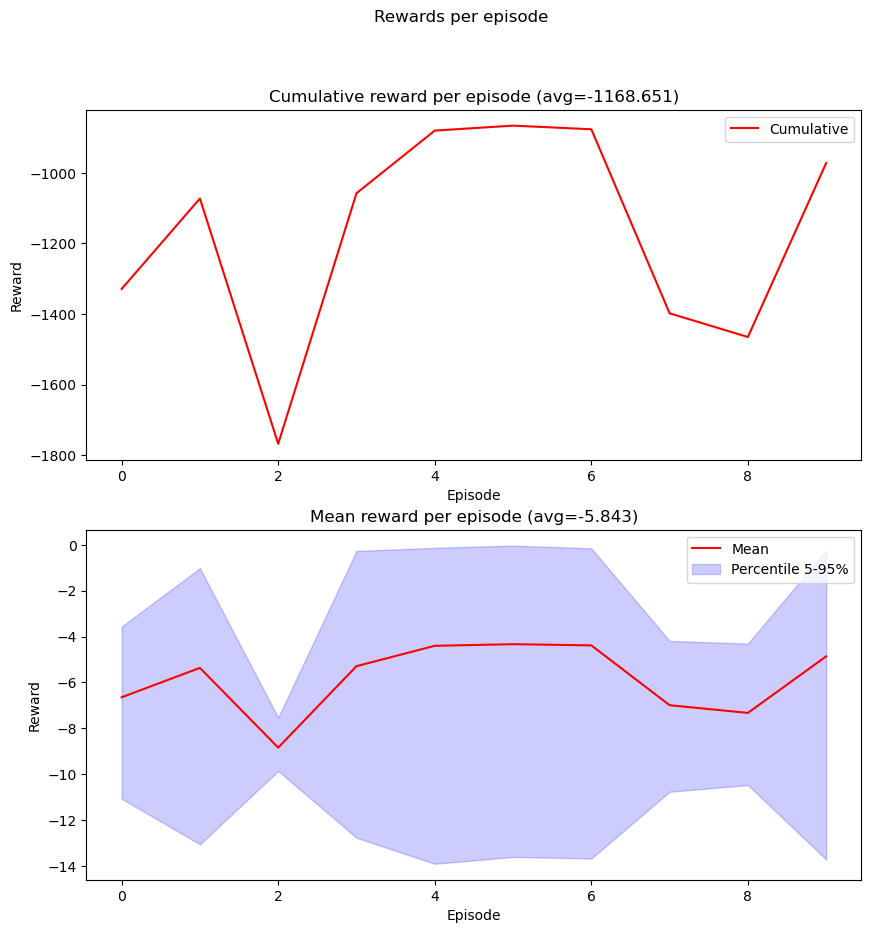

Mean cumulative reward: -1168.650626800077, std: 290.7868123995166


In [9]:
# create environment and actor
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = None
buffer = ReplayBuffer(buffer_size=100000, seed=1)
actor = RandomActor()

# run algorithm
simu = Simulation(
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
step_rewards, cum_rewards = simu.run(num_episodes=10, render=False, plot=True)

print(f"Mean cumulative reward: {np.mean(cum_rewards)}, std: {np.std(cum_rewards)}")

#### Heuristic Agent

Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10
Testing episode: 0/10


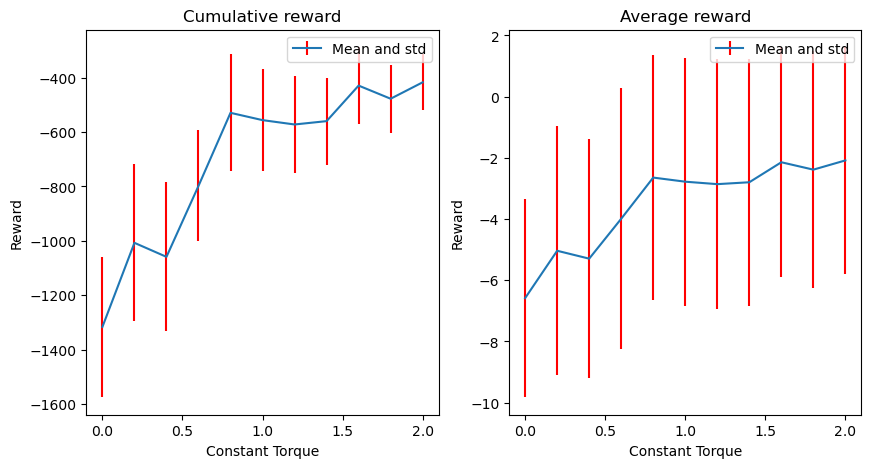

In [10]:
torques = np.linspace(0, 1, 11)

# create environment and actor
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = None
buffer = ReplayBuffer(buffer_size=100000, seed=1)

cum_sums = []
cum_stds = []
step_sums = []
step_stds = []
for torque in torques:
    # create actor
    actor = HeuristicActor(const_torque=torque)

    # run algorithm
    simu = Simulation(
        env=env, 
        critic = critic,
        actor = actor, 
        buffer=buffer,
    )
    step_rewards, cum_rewards = simu.run(num_episodes=10, render=False, plot=False)

    # save mean and std of cumulative and step rewards
    cum_sums.append(np.mean(cum_rewards))
    cum_stds.append(np.std(cum_rewards))
    step_sums.append(np.mean(step_rewards))
    step_stds.append(np.std(step_rewards))

# transform torques in action space [0, 1] to torque space [0, 2]
torques = torques * 2

# plot results
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs[0].errorbar(x=torques, y=cum_sums, yerr=cum_stds, ecolor="red", label="Mean and std")
axs[0].set_xlabel("Constant Torque")
axs[0].set_ylabel("Reward")
axs[0].legend()
axs[0].set_title("Cumulative reward")

axs[1].errorbar(x=torques, y=step_sums, yerr=step_stds, ecolor="red", label="Mean and std")
axs[1].set_xlabel("Constant Torque")
axs[1].set_ylabel("Reward")
axs[1].legend()
axs[1].set_title("Average reward")

plt.show()

/home/danbobr/miniconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/danbobr/miniconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/danbobr/miniconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/danbobr/miniconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/danbobr/miniconda3

Mean cumulative reward for random agent: -1249.0551, std: 287.2782
Mean cumulative reward for |torque|=1: -439.5960, std: 107.0256


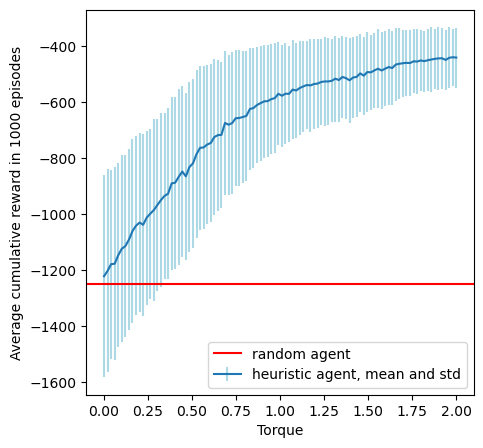

In [11]:
torques = np.linspace(0, 1, 100)

# create environment and actor
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = None
buffer = ReplayBuffer(buffer_size=100000, seed=1)

# run episodes with different torques in parallel
run_experiment = lambda torque: np.array(Simulation(env=env,
                                            critic=critic,
                                            actor=HeuristicActor(const_torque=torque),
                                            buffer=buffer).run(num_episodes=1000, render=False, plot=False, verbose=False)[1])
cum_rewards = np.array(Parallel(n_jobs=10)(delayed(run_experiment)(torque) for torque in torques))
cum_rewards_mean = cum_rewards.mean(axis=1)
cum_rewards_std = cum_rewards.std(axis=1)

# run episodes with random actor
actor = RandomActor()
simu = Simulation( 
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
_, cum_rewards_random = simu.run(num_episodes=1000, render=False, plot=False, verbose=False)

# print cumulative reward
print(f"Mean cumulative reward for random agent: {np.array(cum_rewards_random).mean():.4f}, std: {np.array(cum_rewards_random).std():.4f}")
print(f"Mean cumulative reward for |torque|=1: {cum_rewards_mean[-1]:.4f}, std: {cum_rewards_std[-1]:.4f}")

# plot results
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(x=torques*2, y=cum_rewards_mean, yerr=cum_rewards_std, ecolor="lightblue", label="heuristic agent, mean and std")
ax.axhline(y = np.array(cum_rewards_random).mean(), color = 'r', linestyle = '-', label="random agent")
ax.legend(loc="lower right")
ax.set_xlabel("Torque")
ax.set_ylabel("Average cumulative reward in 1000 episodes")
plt.show()

### Chapter 4 - Q-function

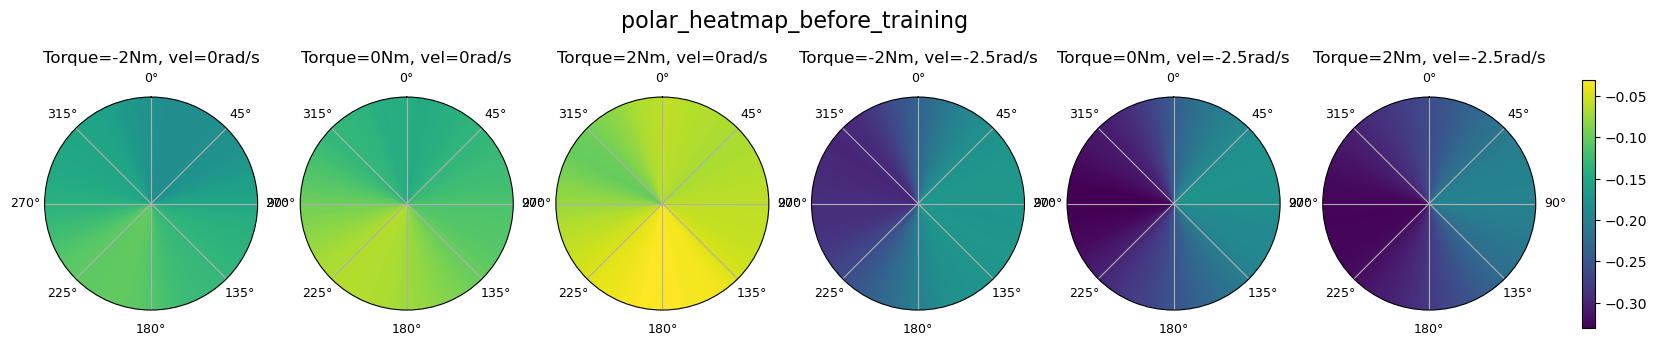

Training episode: 0/1000
Training episode: 10/1000
Training episode: 20/1000
Training episode: 30/1000
Training episode: 40/1000
Training episode: 50/1000
Training episode: 60/1000
Training episode: 70/1000
Training episode: 80/1000
Training episode: 90/1000
Training episode: 100/1000
Training episode: 110/1000
Training episode: 120/1000
Training episode: 130/1000
Training episode: 140/1000
Training episode: 150/1000
Training episode: 160/1000
Training episode: 170/1000
Training episode: 180/1000
Training episode: 190/1000
Training episode: 200/1000
Training episode: 210/1000
Training episode: 220/1000
Training episode: 230/1000
Training episode: 240/1000
Training episode: 250/1000
Training episode: 260/1000
Training episode: 270/1000
Training episode: 280/1000
Training episode: 290/1000
Training episode: 300/1000
Training episode: 310/1000
Training episode: 320/1000
Training episode: 330/1000
Training episode: 340/1000
Training episode: 350/1000
Training episode: 360/1000
Training epi

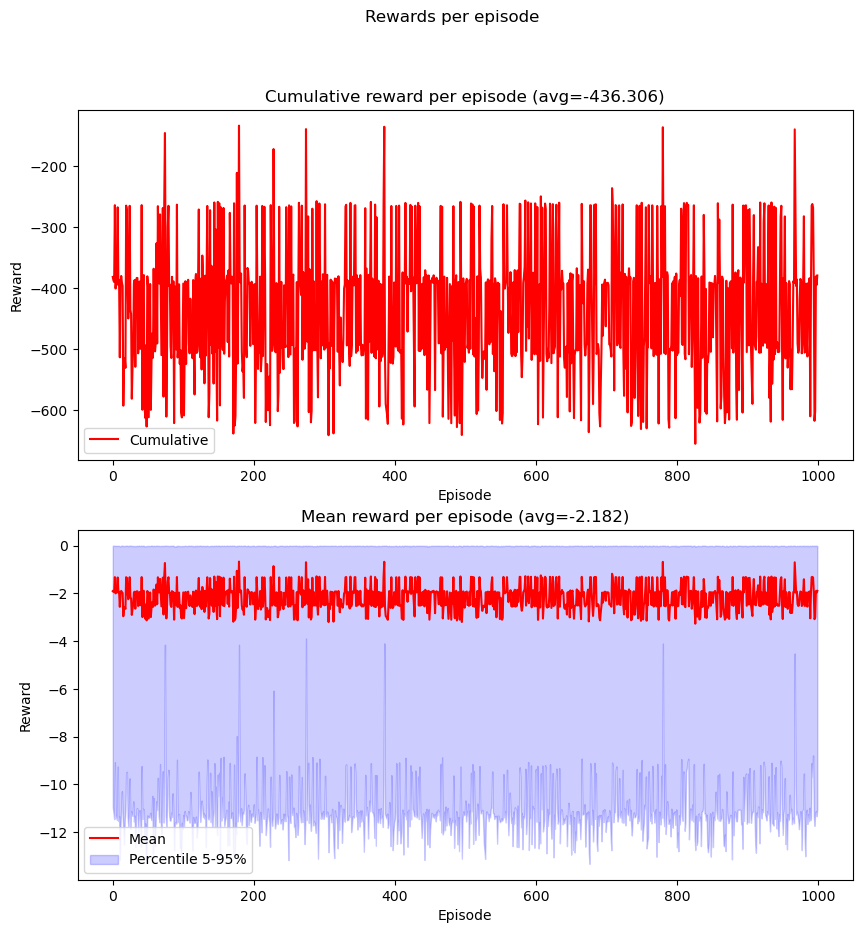

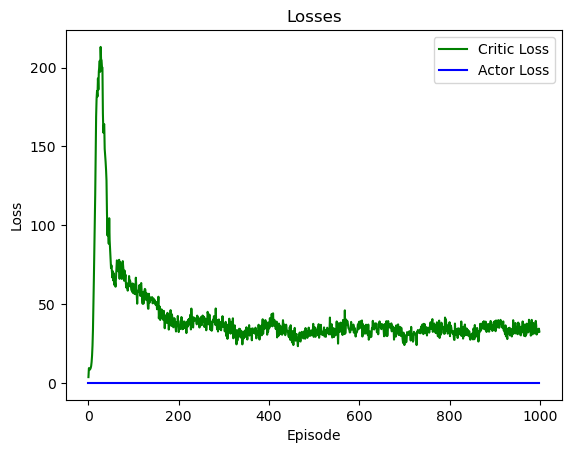

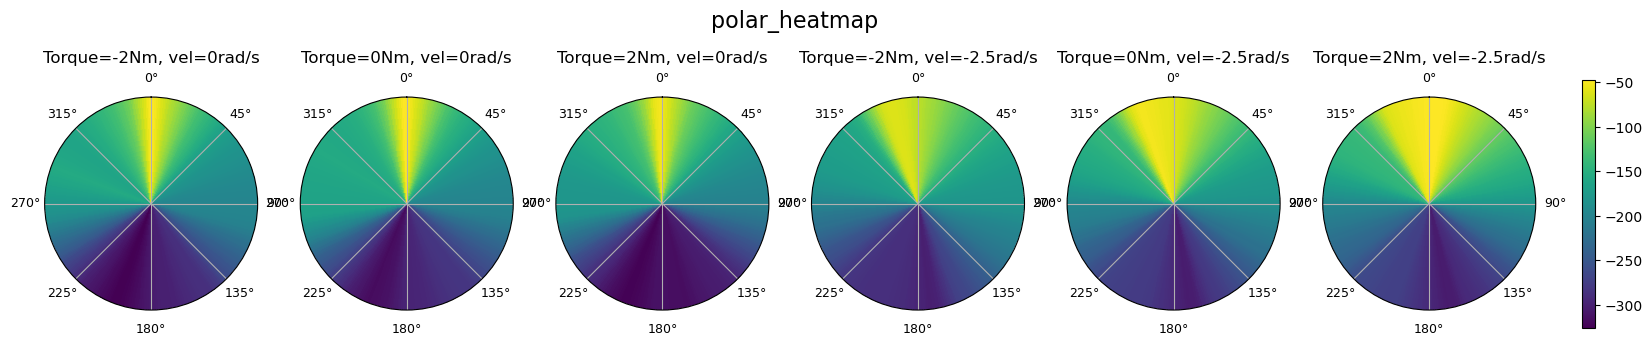

In [12]:
# create environment, critic, actor, noise and buffer
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = Critic(gamma=0.99, lr=1e-4, tau=1.0)
actor = HeuristicActor(const_torque=1.0)
buffer = ReplayBuffer(buffer_size=10000, seed=1)

# train algorithm
simu = Simulation(
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
_, _ = simu.train(num_episodes=1000, batch_size=128)

### Chapter 5 - Minimal Implementation of DDPG

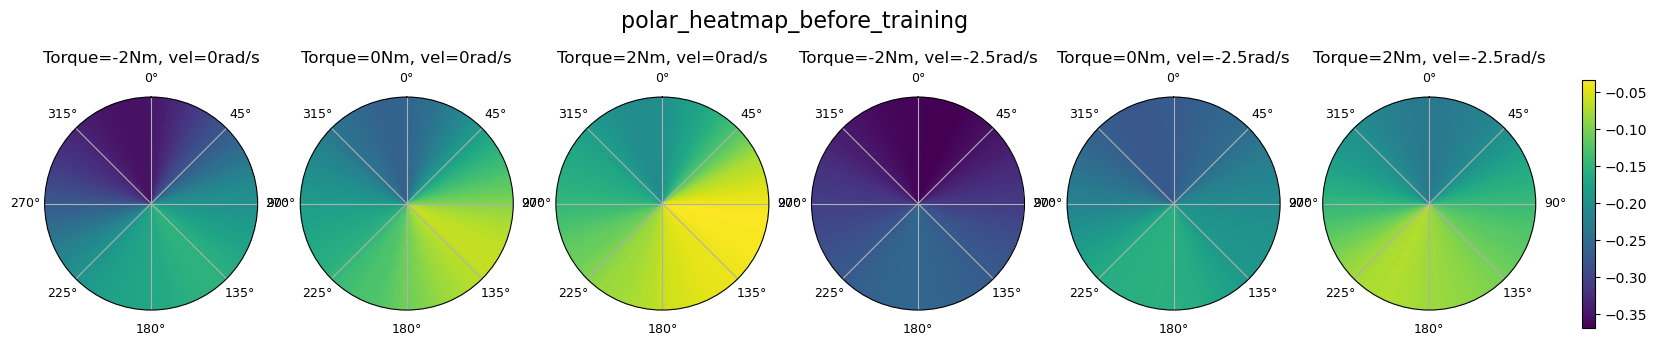

Training episode: 0/1000
Training episode: 10/1000
Training episode: 20/1000
Training episode: 30/1000
Training episode: 40/1000
Training episode: 50/1000
Training episode: 60/1000
Training episode: 70/1000
Training episode: 80/1000
Training episode: 90/1000
Training episode: 100/1000
Training episode: 110/1000
Training episode: 120/1000
Training episode: 130/1000
Training episode: 140/1000
Training episode: 150/1000
Training episode: 160/1000
Training episode: 170/1000
Training episode: 180/1000
Training episode: 190/1000
Training episode: 200/1000
Training episode: 210/1000
Training episode: 220/1000
Training episode: 230/1000
Training episode: 240/1000
Training episode: 250/1000
Training episode: 260/1000
Training episode: 270/1000
Training episode: 280/1000
Training episode: 290/1000
Training episode: 300/1000
Training episode: 310/1000
Training episode: 320/1000
Training episode: 330/1000
Training episode: 340/1000
Training episode: 350/1000
Training episode: 360/1000
Training epi

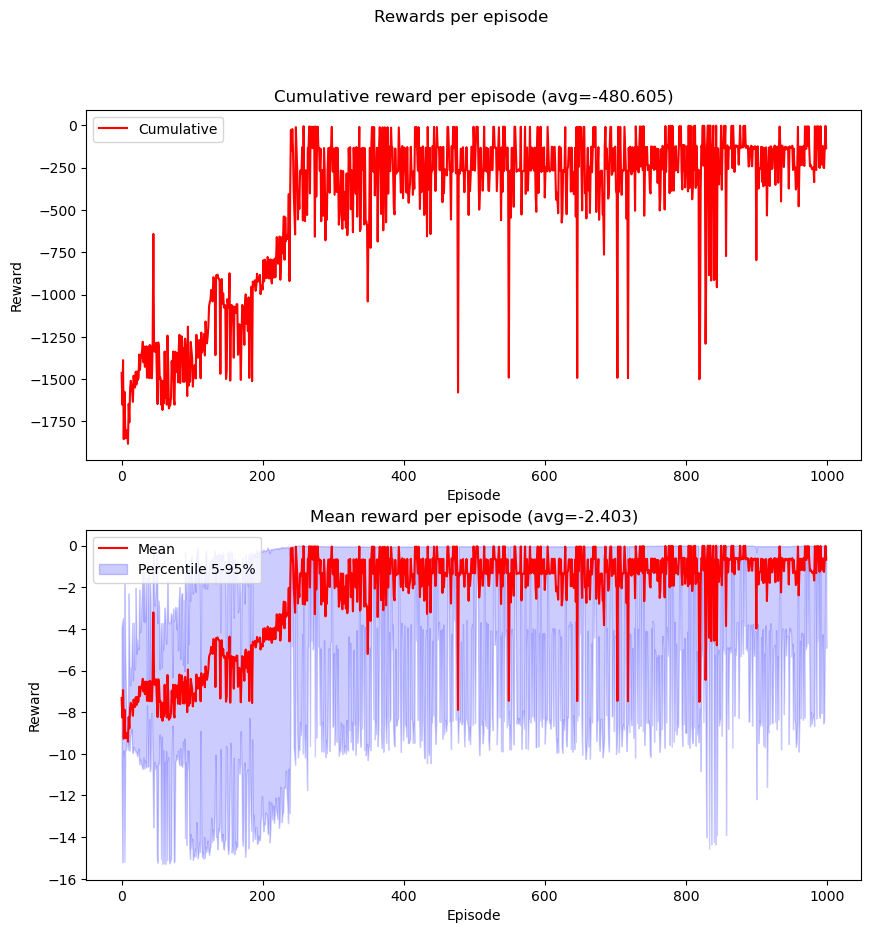

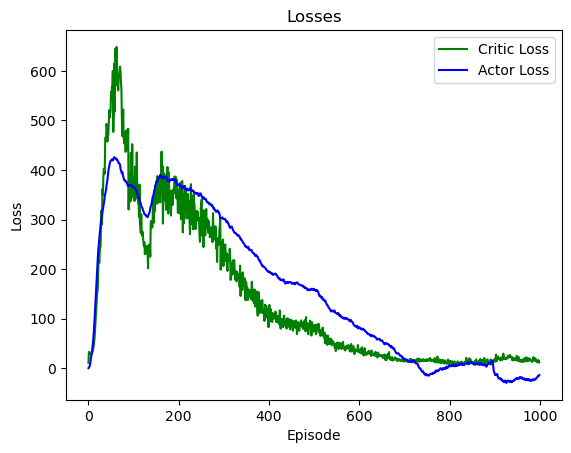

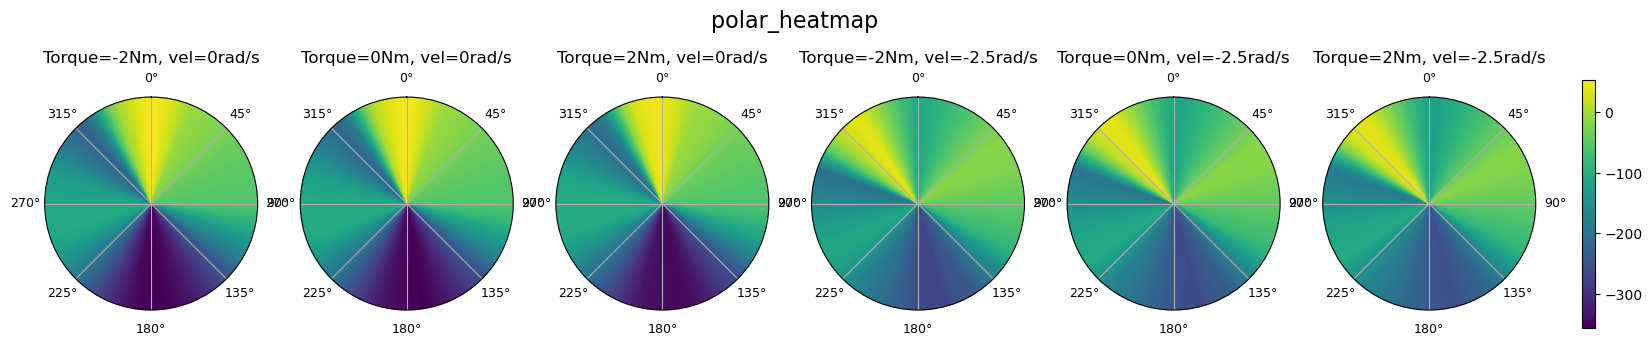

Testing episode: 0/100
Testing episode: 10/100
Testing episode: 20/100
Testing episode: 30/100
Testing episode: 40/100
Testing episode: 50/100
Testing episode: 60/100
Testing episode: 70/100
Testing episode: 80/100
Testing episode: 90/100


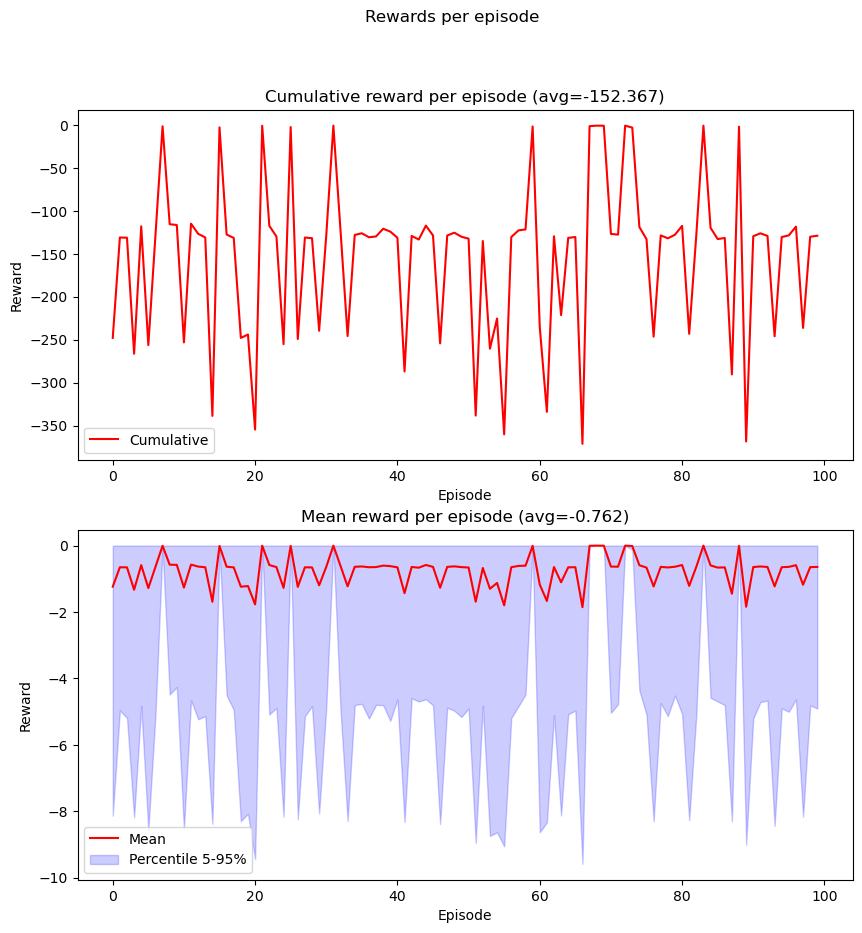

In [13]:
# create environment, critic, actor, noise and buffer
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = Critic(gamma=0.99, lr=1e-4, tau=1.0)
action_noise = GaussianActionNoise(sigma=0.3, seed=0)
actor = Actor(lr=1e-4, tau=1.0, noise=action_noise)
buffer = ReplayBuffer(buffer_size=100000, seed=1)

# train algorithm
simu = Simulation(
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
_, _ = simu.train(num_episodes=1000, batch_size=128)
_, _ = simu.run(num_episodes=100, render=False, plot=True)

### Chapter 6 - Target DDPG

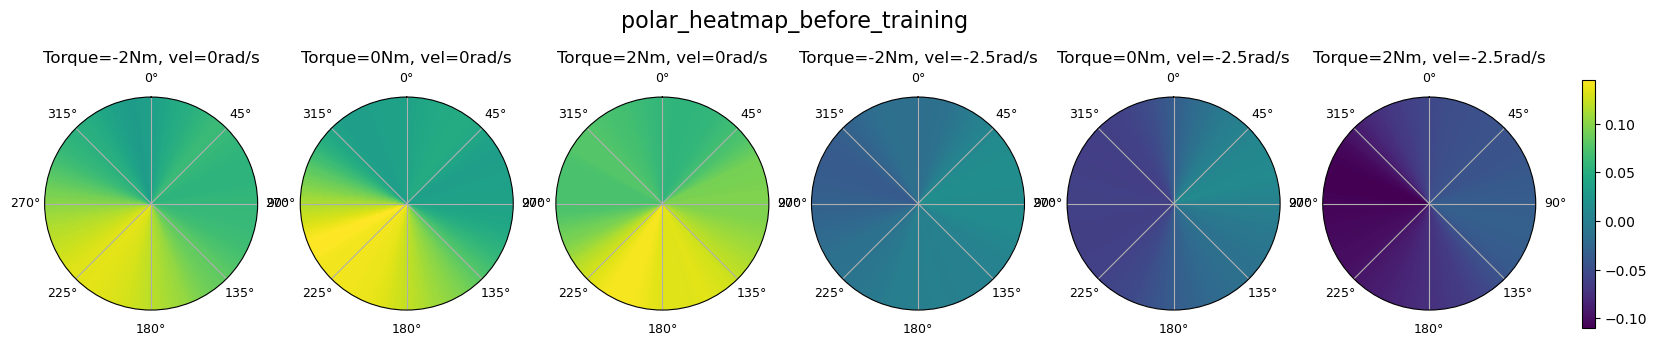

Training episode: 0/1000
Training episode: 10/1000
Training episode: 20/1000
Training episode: 30/1000
Training episode: 40/1000
Training episode: 50/1000
Training episode: 60/1000
Training episode: 70/1000
Training episode: 80/1000
Training episode: 90/1000
Training episode: 100/1000
Training episode: 110/1000
Training episode: 120/1000
Training episode: 130/1000
Training episode: 140/1000
Training episode: 150/1000
Training episode: 160/1000
Training episode: 170/1000
Training episode: 180/1000
Training episode: 190/1000
Training episode: 200/1000
Training episode: 210/1000
Training episode: 220/1000
Training episode: 230/1000
Training episode: 240/1000
Training episode: 250/1000
Training episode: 260/1000
Training episode: 270/1000
Training episode: 280/1000
Training episode: 290/1000
Training episode: 300/1000
Training episode: 310/1000
Training episode: 320/1000
Training episode: 330/1000
Training episode: 340/1000
Training episode: 350/1000
Training episode: 360/1000
Training epi

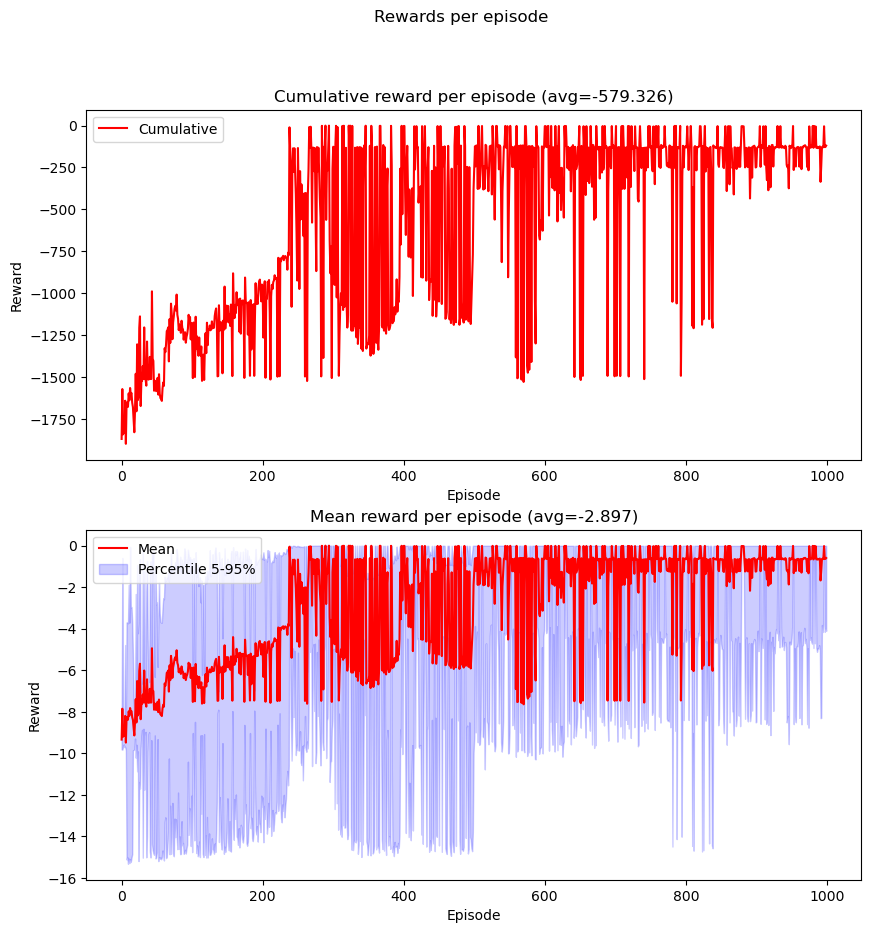

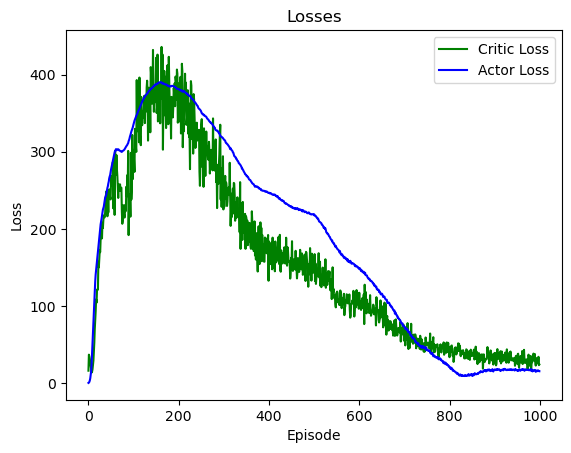

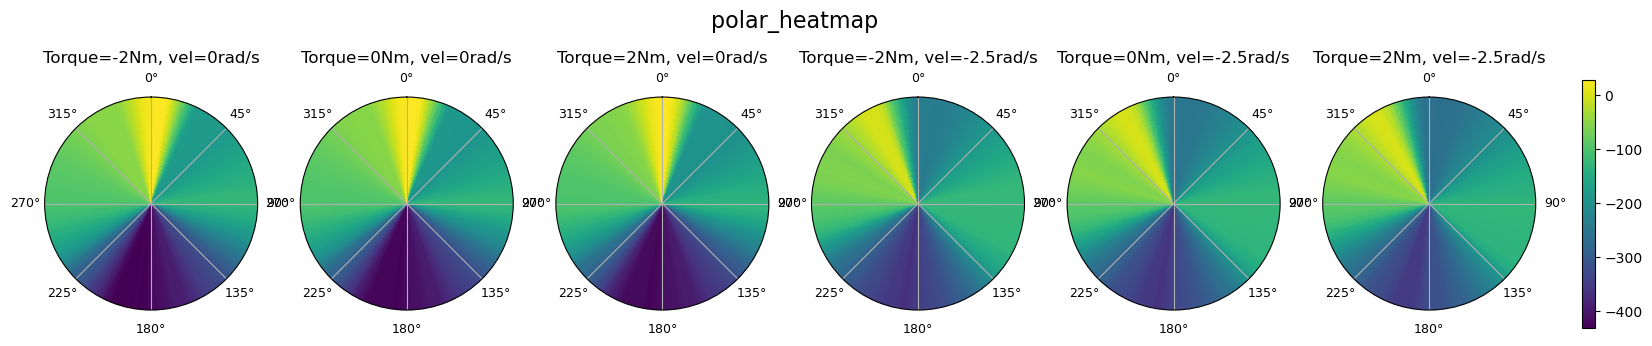

Testing episode: 0/100
Testing episode: 10/100
Testing episode: 20/100
Testing episode: 30/100
Testing episode: 40/100
Testing episode: 50/100
Testing episode: 60/100
Testing episode: 70/100
Testing episode: 80/100
Testing episode: 90/100


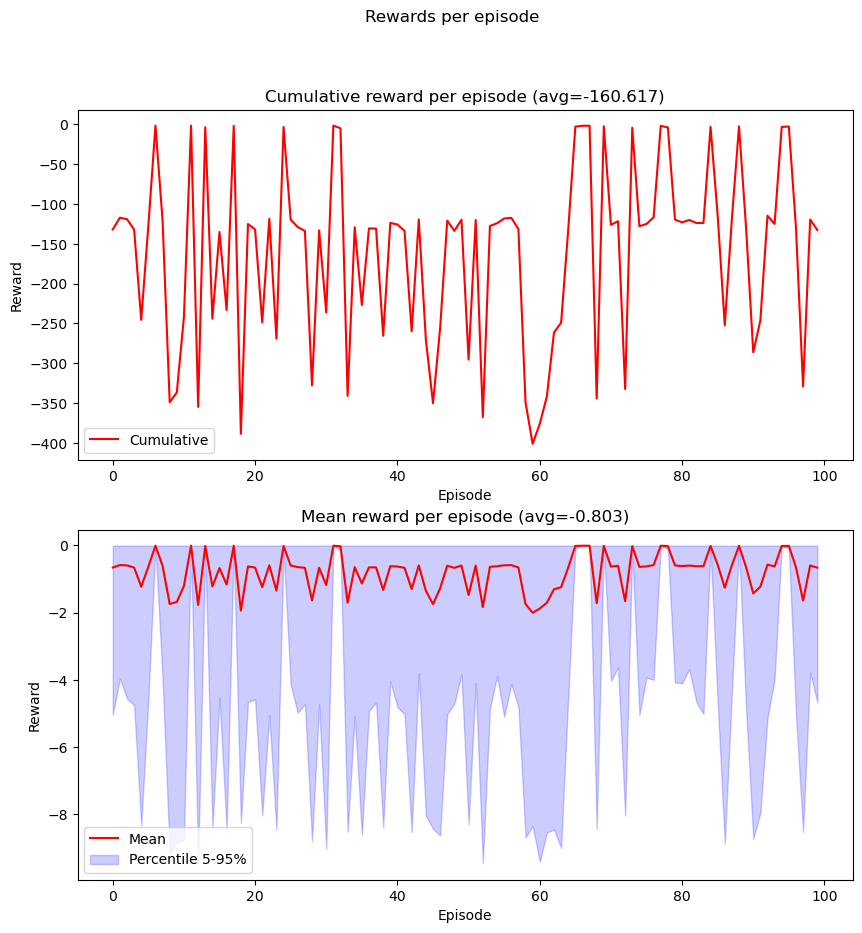

In [10]:
# target network update
tau = 0.01

# create environment, critic, actor, noise and buffer
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = Critic(gamma=0.99, lr=1e-4, tau=tau)
action_noise = GaussianActionNoise(sigma=0.3, seed=0)
actor = Actor(lr=1e-4, tau=tau, noise=action_noise)
buffer = ReplayBuffer(buffer_size=100000, seed=1)

# train algorithm
simu = Simulation( 
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
_, _ = simu.train(num_episodes=1000, batch_size=128)
_, _ = simu.run(num_episodes=100, render=False, plot=True)

### Chapter 7 - Ornstein-Uhlenbeck Noise

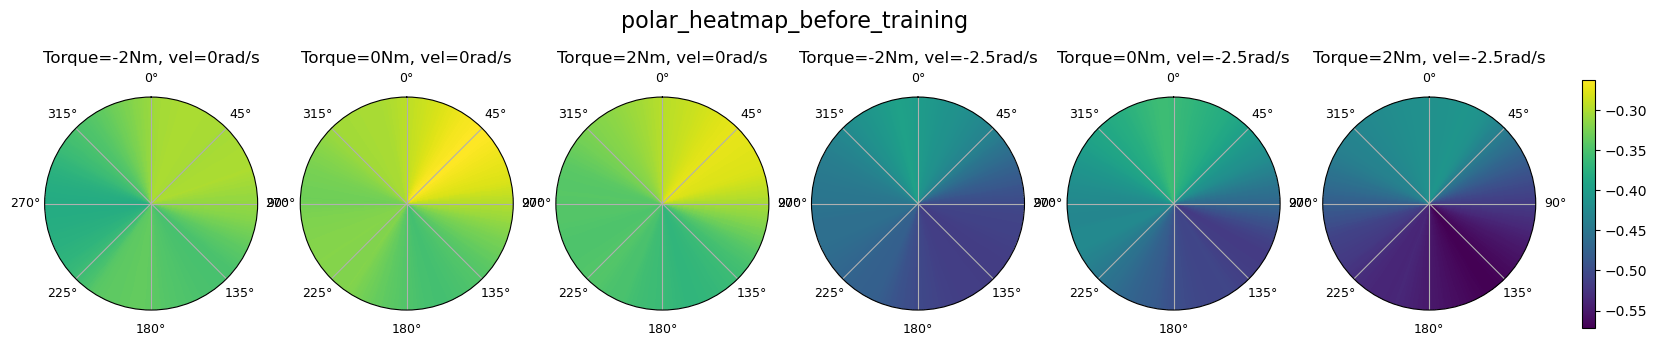

Training episode: 0/1000
Training episode: 10/1000
Training episode: 20/1000
Training episode: 30/1000
Training episode: 40/1000
Training episode: 50/1000
Training episode: 60/1000
Training episode: 70/1000
Training episode: 80/1000
Training episode: 90/1000
Training episode: 100/1000
Training episode: 110/1000
Training episode: 120/1000
Training episode: 130/1000
Training episode: 140/1000
Training episode: 150/1000
Training episode: 160/1000
Training episode: 170/1000
Training episode: 180/1000
Training episode: 190/1000
Training episode: 200/1000
Training episode: 210/1000
Training episode: 220/1000
Training episode: 230/1000
Training episode: 240/1000
Training episode: 250/1000
Training episode: 260/1000
Training episode: 270/1000
Training episode: 280/1000
Training episode: 290/1000
Training episode: 300/1000
Training episode: 310/1000
Training episode: 320/1000
Training episode: 330/1000
Training episode: 340/1000
Training episode: 350/1000
Training episode: 360/1000
Training epi

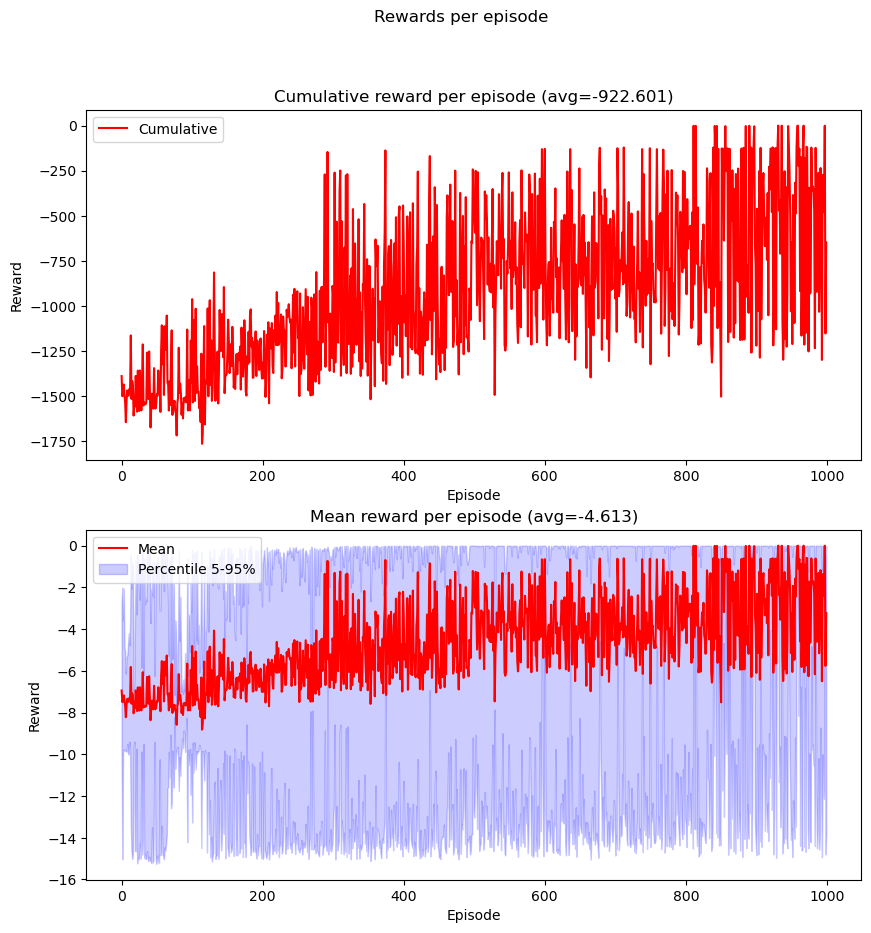

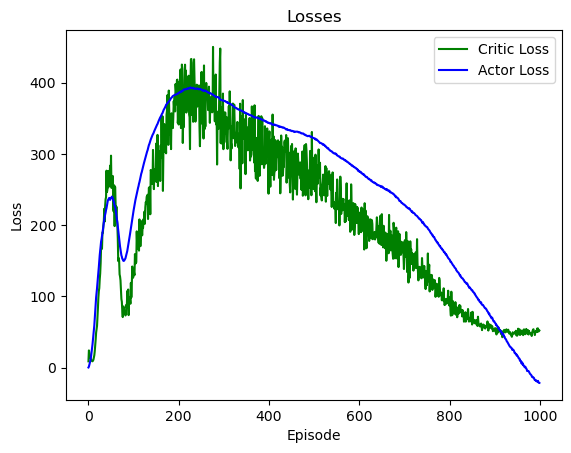

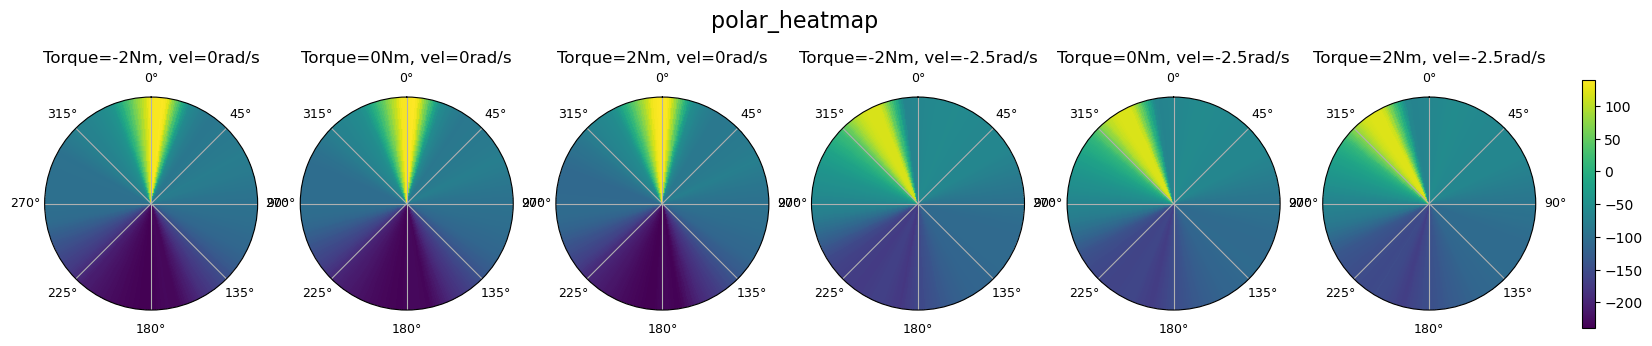

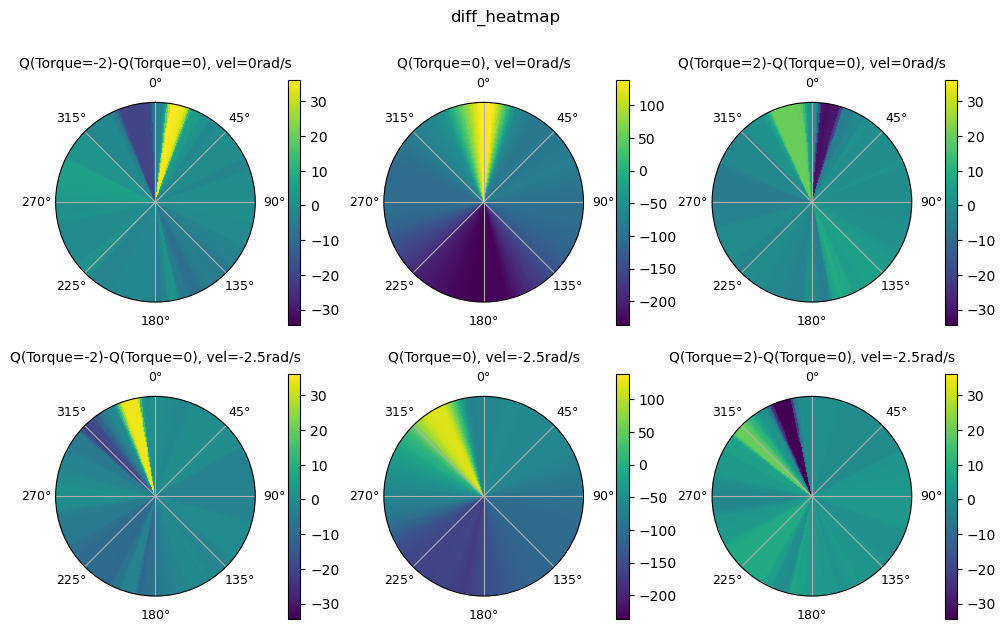

Testing episode: 0/100
Testing episode: 10/100
Testing episode: 20/100
Testing episode: 30/100
Testing episode: 40/100
Testing episode: 50/100
Testing episode: 60/100
Testing episode: 70/100
Testing episode: 80/100
Testing episode: 90/100


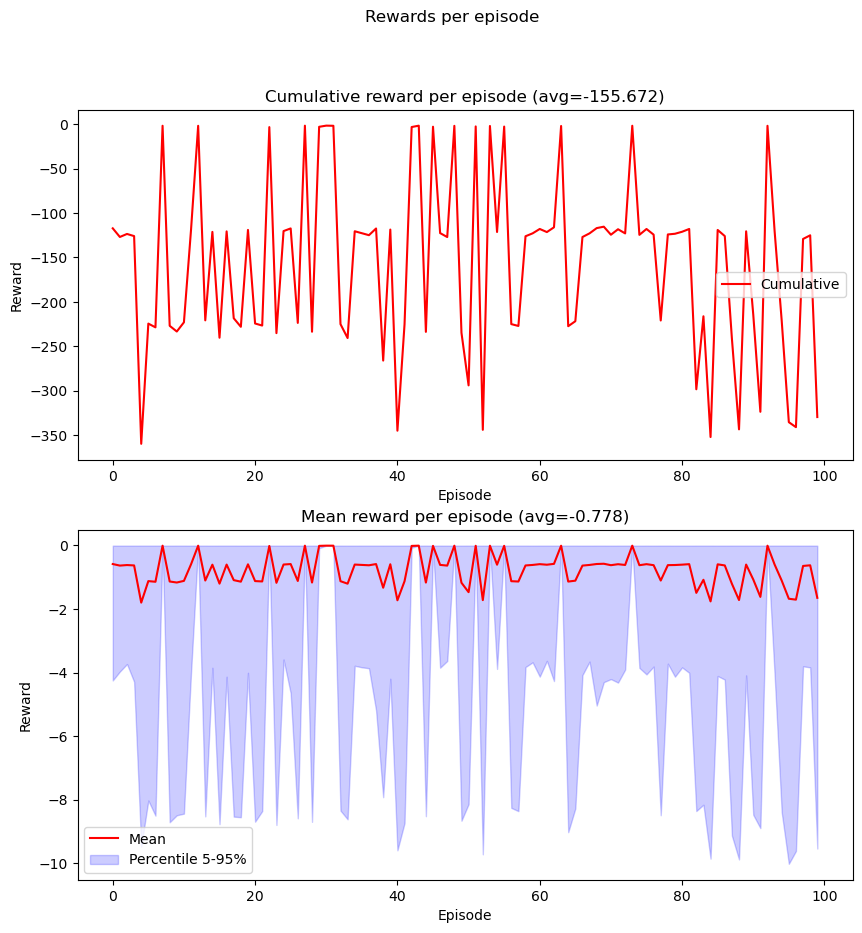

In [12]:
# OU noise parameter
theta = 0.0

# create environment, critic, actor, noise and buffer
env = NormalizedEnv(env=gym.make("Pendulum-v1", render_mode="rgb_array"))
critic = Critic(gamma=0.99, lr=1e-4, tau=0.01)
action_noise = OUActionNoise(sigma=0.3, theta=theta, seed=0)
actor = Actor(lr=1e-4, tau=0.01, noise=action_noise)
buffer = ReplayBuffer(buffer_size=100000, seed=1)

# train algorithm
simu = Simulation(
    env=env, 
    critic = critic,
    actor = actor, 
    buffer=buffer,
)
_, _ = simu.train(num_episodes=1000, batch_size=128)
_, _ = simu.run(num_episodes=100, render=False, plot=True)

### Code to reproduce the exact figures from the report

The code below allows you to reproduce the training curves from the report. To run it, you need to clone a GitHub repo to access the files with losses of the models that we used for the report.

GitHub: https://github.com/nas-git-nas/ANNRL_Project_DDPG

In [ ]:
def plotLosses(dir, path, plot_actor=True):
    """
    Plot the losses and cumulative reward of a single model.

    Parameters:
        dir (str): path to the directory containing the losses.csv file
        path (str): path to the directory where the plot will be saved
        plot_actor (bool): whether to plot the actor loss or not; without actor cumulative reward is also not plotted
    """
    if plot_actor:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
        df = pd.read_csv(os.path.join(dir, "losses.csv"))

        # calculate moving average of cumulative rewards across 10 episodes
        cum_rewards = df["cum_rewards"].rolling(30).mean()

        axs[0].plot(range(len(df["critic"])), df["critic"].to_numpy(), color="green", label="Critic loss")
        axs[0].plot(range(len(df["actor"])), df["actor"].to_numpy(), color="blue", label="Actor loss")
        axs[1].plot(range(len(df["cum_rewards"])), cum_rewards, color="blue", label="Cumulative reward")

        axs[0].set_xlabel("Episode")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[0].set_title(f"Losses")

        axs[1].set_xlabel("Episode")
        axs[1].set_ylabel("Cumulative reward")
        axs[1].legend()
        axs[1].set_title(f"Cumulative reward")

        plt.savefig(os.path.join(path, "losses_rewards.pdf"), bbox_inches='tight')
    
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
        df = pd.read_csv(os.path.join(dir, "losses.csv"))

        ax.plot(range(len(df["critic"])), df["critic"].to_numpy(), color="green", label="Critic loss")

        ax.set_xlabel("Episode")
        ax.set_ylabel("Critic loss")
        
        plt.savefig(os.path.join(path, "critic_loss.pdf"), bbox_inches='tight')

def plotReplicateLosses(dirs, path):
    """
    Plot the losses and cumulative rewards of multiple runs of a single model.

    Parameters:
        dirs (list): list of paths to the directories containing the losses.csv files
        path (str): path to the directory where the plot will be saved
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    for i, dir_path in enumerate(dirs):
        df = pd.read_csv(os.path.join(dir_path, "losses.csv"))

        # calculate moving average of cumulative rewards across 10 episodes
        cum_rewards = df["cum_rewards"].rolling(30).mean()

        axs[0].plot(range(len(df["critic"])), df["critic"].to_numpy(), linewidth=0.8, label=f"Run {i}")
        axs[1].plot(range(len(df["actor"])), df["actor"].to_numpy(), label=f"Run {i}")
        axs[2].plot(range(len(df["cum_rewards"])), cum_rewards, label=f"Run {i}")

    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Critic loss")
    axs[0].legend()
    axs[0].set_title(f"Critic loss")

    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Actor loss")
    axs[1].legend()
    axs[1].set_title(f"Actor loss")

    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Cumulative reward")
    axs[2].legend()
    axs[2].set_title(f"Cumulative reward")

    fig.tight_layout()

    plt.savefig(os.path.join(path, "replicate_losses.pdf"), bbox_inches='tight')

def plotMultipleLosses(dirs, path, labeltheta=True):
    """
    Plot the losses and cumulative rewards of multiple models.

    Parameters:
        dirs (list): list of paths to the directories containing the losses.csv files
        path (str): path to the directory where the plot will be saved
        labeltheta (bool): whether to label thetas or not
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    for dir_path in dirs:
        df = pd.read_csv(os.path.join(dir_path, "losses.csv"))

        # calculate moving average of cumulative rewards across 10 episodes
        cum_rewards = df["cum_rewards"].rolling(30).mean()

        if labeltheta:
            axs[0].plot(range(len(df["critic"])), df["critic"].to_numpy(), linewidth=0.8, label="theta="+str(df["theta"][0]))
            axs[1].plot(range(len(df["actor"])), df["actor"].to_numpy(), label="theta="+str(df["theta"][0]))
            axs[2].plot(range(len(df["cum_rewards"])), cum_rewards, label="theta="+str(df["theta"][0]))
        else:
            axs[0].plot(range(len(df["critic"])), df["critic"].to_numpy(), linewidth=0.8, label="tau="+str(df["tau"][0]))
            axs[1].plot(range(len(df["actor"])), df["actor"].to_numpy(), label="tau="+str(df["tau"][0]))
            axs[2].plot(range(len(df["cum_rewards"])), cum_rewards, label="tau="+str(df["tau"][0]))

    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].set_title(f"Critic loss")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].set_title(f"Actor loss")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Cumulative reward")
    axs[2].legend(loc="lower right")
    axs[2].set_title(f"Cumulative reward")

    fig.tight_layout()

    plt.savefig(os.path.join(path, "multiple_losses.pdf"), bbox_inches='tight')

In [ ]:
# plot Q-networks losses
dir_qnet = "results/4_qvalues/20230527_1629"
plotLosses(dir=dir_qnet, path=dir_qnet, plot_actor=False)

# plot minimal DDPG losses for two runs
dirs_ddpg = ["results/5_simple_ddpg/20230526_1531_tau1.0_theta1.0",
            "results/5_simple_ddpg/20230526_1559_tau1.0_theta1.0"]
plotReplicateLosses(dirs=dirs_ddpg, path="results/5_simple_ddpg")

# plot target DDPG losses
dirs_target = ["results/6_target_ddpg/20230526_1841_tau0.01_theta1.0",
                "results/6_target_ddpg/20230527_1614_tau0.05_theta1.0",
                "results/6_target_ddpg/20230526_1714_tau0.1_theta1.0",
                "results/6_target_ddpg/20230526_1659_tau0.5_theta1.0",
                "results/6_target_ddpg/20230526_1633_tau1.0_theta1.0"]
plotMultipleLosses(dirs=dirs_target, path="results/6_target_ddpg", labeltheta=False)

# plot OU noise DDPG losses
dirs_ou = ["results/7_ou_noise_ddpg/20230527_1434_tau0.01_theta0.0",
            "results/7_ou_noise_ddpg/20230527_1407_tau0.01_theta0.25",
            "results/7_ou_noise_ddpg/20230527_1353_tau0.01_theta0.5",
            "results/7_ou_noise_ddpg/20230527_1334_tau0.01_theta0.75",
            "results/7_ou_noise_ddpg/20230527_1455_tau0.01_theta1.0"]
plotMultipleLosses(dirs=dirs_ou, path="results/7_ou_noise_ddpg") 